In [66]:
# Preprocessing
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from timeit import default_timer as timer

%matplotlib inline
plt.style.use("bmh")

path = Path.cwd().parent / "mdsb-2023"

In [67]:
def train_test_split_temporal(X, y, delta_threshold="60 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

### Define pipeline functions

In [68]:
def _encode_dates(X, col_name="date"):
    X = X.copy()

    X["month"] = X[col_name].dt.month
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour

    X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])


def full_encode(X):
    return _encode_dates(X)

In [69]:
def get_pipeline():
    date_encoder = FunctionTransformer(_encode_dates, validate=False)

    cat_encoder = OneHotEncoder(handle_unknown="ignore")
    scaler = StandardScaler()

    regressor = XGBRegressor()

    preprocessor = ColumnTransformer(
        [
            # ('scaler', scaler, scaling_columns),  # Scaling is making it worse
            ("cat", cat_encoder, categorical_cols),
        ]
    )

    pipe = Pipeline(
        [
            ("date encoder", date_encoder),
            ("preprocessor", preprocessor),
            ("regressor", regressor),
        ]
    )

    return pipe

## Import main dataset

In [70]:
data = pd.read_parquet(path / "train.parquet")

targets = ["bike_count", "log_bike_count"]

In [71]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Model

In [72]:
X, y = data.drop(columns=targets), data["log_bike_count"]

In [73]:
date_cols = (
    _encode_dates(X[["date"]]).select_dtypes(include="category").columns.tolist()
)
categorical_cols = ["counter_name"] + date_cols

In [74]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [75]:
pipe = get_pipeline()

pipe.fit(X_train, y_train)

Pipeline(steps=[('date encoder',
                 FunctionTransformer(func=<function _encode_dates at 0x00000231D66691B0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'month',
                                                   'weekday', 'hour'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynod...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [76]:
y_hat = pipe.predict(X_test)
y_hat[y_hat < 0] = 0

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

Train set, RMSE=0.56
Test set, RMSE=0.68


## Prediction visualization

In [77]:
rmse_per_counter = []

for c in X_test["counter_name"].unique():
    # Filter predictions and actual values based on the counter
    y_hat_counter = y_hat[X_test["counter_name"] == c]
    y_test_counter = y_test[X_test["counter_name"] == c]

    # Calculate RMSE for the current counter
    rmse = mean_squared_error(y_test_counter, y_hat_counter, squared=False)

    # Store results in the list
    rmse_per_counter.append({"Counter": c, "Test set RMSE": rmse})

# Convert the list to a DataFrame
rmse_per_counter = pd.DataFrame(rmse_per_counter)

# Sort the DataFrame based on the "Counter" column
rmse_per_counter = rmse_per_counter.sort_values(by="Test set RMSE", ascending=False)

# Print the sorted table
print(rmse_per_counter)

                                            Counter  Test set RMSE
52                        20 Avenue de Clichy NO-SE       1.760038
53                        20 Avenue de Clichy SE-NO       1.557126
50                           90 Rue De Sèvres NE-SO       1.119747
51                           90 Rue De Sèvres SO-NE       0.995434
40                                 Quai d'Orsay E-O       0.747029
47                         Totem Cours la Reine O-E       0.718127
35                     Face au 40 quai D'Issy SO-NE       0.713736
42                    27 quai de la Tournelle NO-SE       0.708692
24                          Pont de la Concorde S-N       0.701281
46                         Totem Cours la Reine E-O       0.697525
0                          28 boulevard Diderot E-O       0.693087
54                       254 rue de Vaugirard NE-SO       0.669263
34                     Face au 40 quai D'Issy NE-SO       0.662730
14                     Face au 70 quai de Bercy S-N       0.65

Plot predictions for counters with worst residuals

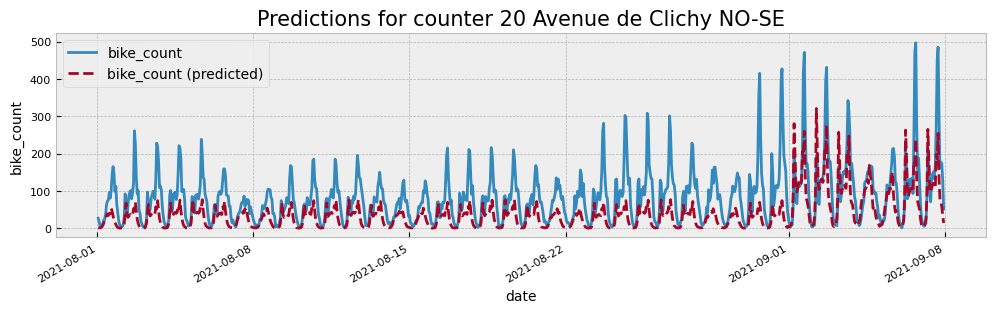

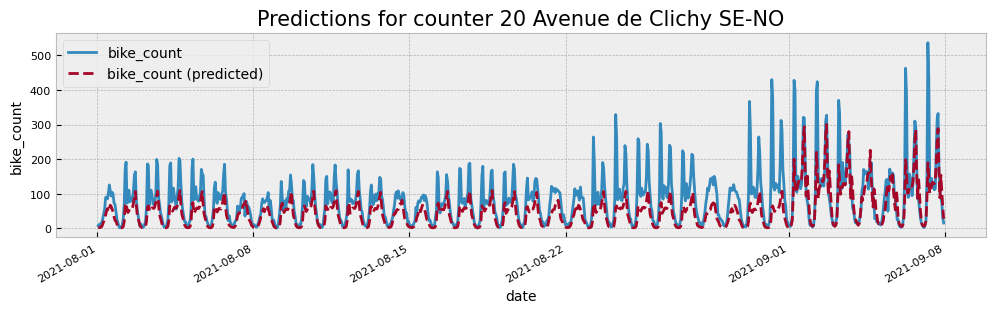

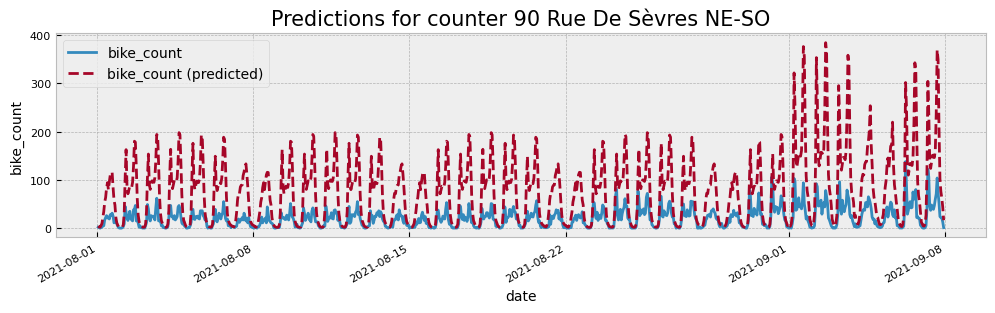

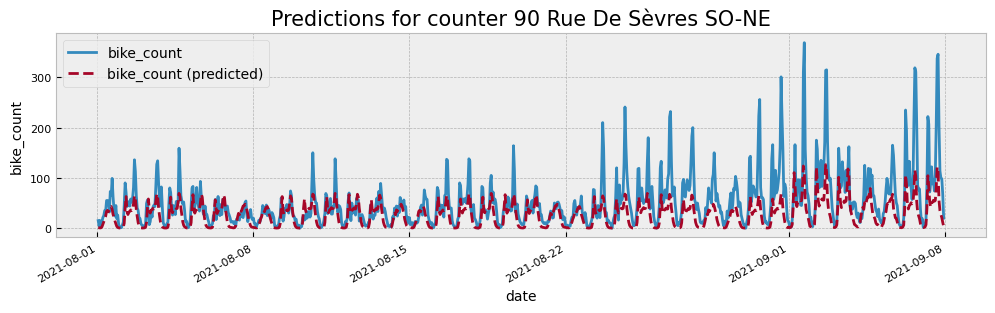

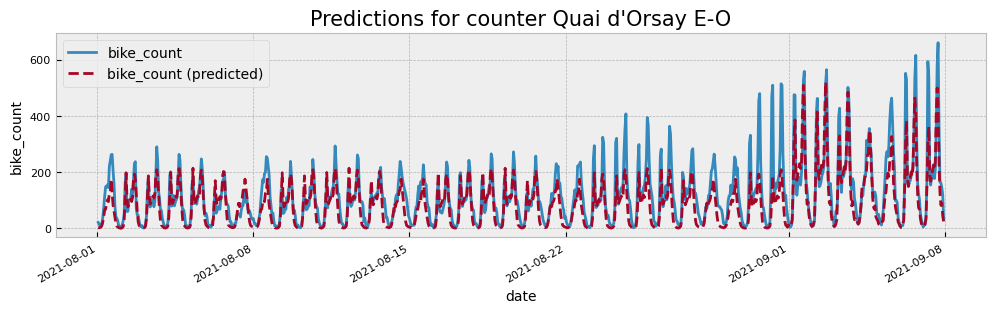

In [78]:
for c in rmse_per_counter["Counter"].iloc[:5]:
    mask = (
        (X_test["counter_name"] == c)
        & (X_test["date"] > pd.to_datetime("2021/08/01"))
        & (X_test["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 3))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title(f"Predictions for counter {c}", fontsize=15)
    ax.set_ylabel("bike_count")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()